In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset we can play with. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

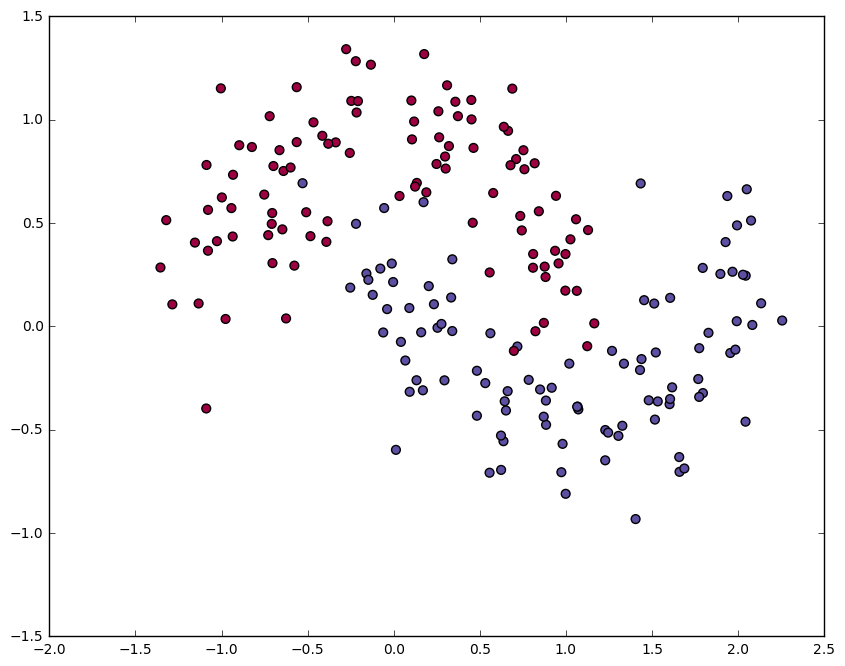

In [29]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [3]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

In [4]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [5]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [6]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [19]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True) # keepdims=True, 不是必须
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model

# Exercises

Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.


---

#### 1. mini batch

In [27]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model_mini(nn_hdim, num_passes=20000, print_loss=False, batch_size=10):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        for j in xrange(0, num_examples/batch_size):
            # mini_batch
            idx = np.random.choice(X.shape[0], batch_size, replace=False)
            X_mini = X[idx, :]
            y_mini = y[idx]
            
            # Forward propagation
            z1 = X_mini.dot(W1) + b1
            a1 = np.tanh(z1)
            z2 = a1.dot(W2) + b2
            exp_scores = np.exp(z2)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Backpropagation
            delta3 = probs
            delta3[range(batch_size), y_mini] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True) # keepdims=True, 不是必须
            delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            dW1 = np.dot(X_mini.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model

Loss after iteration 0: 0.669814
Loss after iteration 1000: 0.092873
Loss after iteration 2000: 0.081906
Loss after iteration 3000: 0.080354
Loss after iteration 4000: 0.078313
Loss after iteration 5000: 0.078481
Loss after iteration 6000: 0.079853
Loss after iteration 7000: 0.078204
Loss after iteration 8000: 0.080346
Loss after iteration 9000: 0.078659
Loss after iteration 10000: 0.078607
Loss after iteration 11000: 0.078435
Loss after iteration 12000: 0.079799
Loss after iteration 13000: 0.078977
Loss after iteration 14000: 0.080437
Loss after iteration 15000: 0.079718
Loss after iteration 16000: 0.083277
Loss after iteration 17000: 0.080443
Loss after iteration 18000: 0.078577
Loss after iteration 19000: 0.079060


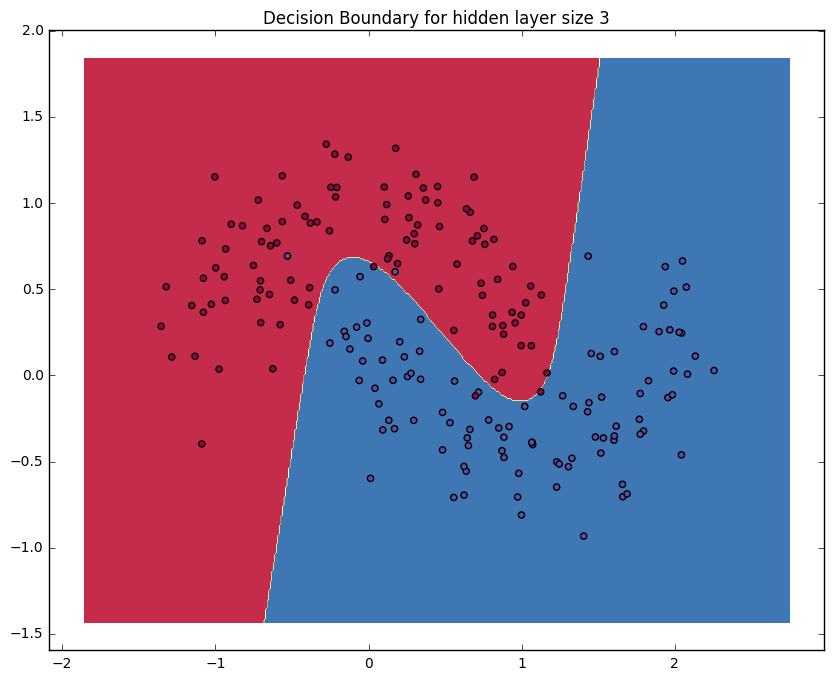

In [30]:
# Build a model with a 3-dimensional hidden layer
model = build_model_mini(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

---

#### 2. annealing schedule

$$\alpha = \frac{\alpha_0}{(1+kt)}$$

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model_mini_annealing(nn_hdim, num_passes=20000, print_loss=False, batch_size=40, alpha=1, k=0.005):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        epsilon = alpha / (1+k*i) # alpha=1 k=0.005
        # epsilon = alpha * np.exp(-k*i) # alpha=5 k=0.0005
        # epsilon = 0.02
        for j in xrange(0, num_examples/batch_size):
            # mini_batch
            idx = np.random.choice(X.shape[0], batch_size, replace=False)
            X_mini = X[idx, :]
            y_mini = y[idx]
            
            # Forward propagation
            z1 = X_mini.dot(W1) + b1
            a1 = np.tanh(z1)
            z2 = a1.dot(W2) + b2
            exp_scores = np.exp(z2)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Backpropagation
            delta3 = probs
            delta3[range(batch_size), y_mini] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True) # keepdims=True, 不是必须
            delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            dW1 = np.dot(X_mini.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f, epsilon: %f" %(i, calculate_loss(model), epsilon)
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model_mini_annealing(3, print_loss=True)

Loss after iteration 0: 61.218091, epsilon: 1.000000
Loss after iteration 1000: 1.030877, epsilon: 0.166667
Loss after iteration 2000: 0.494735, epsilon: 0.090909
Loss after iteration 3000: 0.388092, epsilon: 0.062500
Loss after iteration 4000: 0.334840, epsilon: 0.047619
Loss after iteration 5000: 0.323620, epsilon: 0.038462
Loss after iteration 6000: 0.334584, epsilon: 0.032258
Loss after iteration 7000: 0.370026, epsilon: 0.027778
Loss after iteration 8000: 0.340723, epsilon: 0.024390
Loss after iteration 9000: 0.401609, epsilon: 0.021739
Loss after iteration 10000: 0.320000, epsilon: 0.019608
Loss after iteration 11000: 0.384676, epsilon: 0.017857
Loss after iteration 12000: 0.316349, epsilon: 0.016393
Loss after iteration 13000: 0.342404, epsilon: 0.015152
Loss after iteration 14000: 0.313787, epsilon: 0.014085
Loss after iteration 15000: 0.318749, epsilon: 0.013158
Loss after iteration 16000: 0.330257, epsilon: 0.012346
Loss after iteration 17000: 0.315955, epsilon: 0.011628
Loss

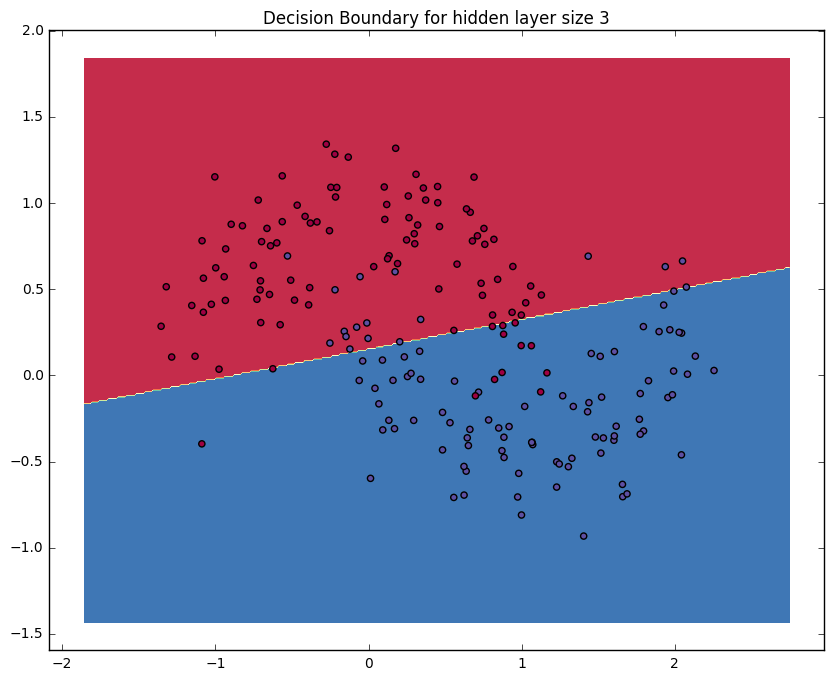

In [10]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

---

#### 3. other acitvation function

+ ReLU
+ sigmoid

In [40]:
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

epsilon = 0.01
    
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model_mini_relu(nn_hdim, num_passes=20000, print_loss=False, batch_size=200):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        for j in xrange(0, num_examples/batch_size):
            # mini_batch
            idx = np.random.choice(X.shape[0], batch_size, replace=False)
            X_mini = X[idx, :]
            y_mini = y[idx]
            
            # Forward propagation
            z1 = X_mini.dot(W1) + b1
            a1 = relu(z1)
            z2 = a1.dot(W2) + b2
            exp_scores = np.exp(z2)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Backpropagation
            delta3 = probs
            delta3[range(batch_size), y_mini] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True) # keepdims=True, 不是必须
            delta2 = delta3.dot(W2.T) * drelu(z1)
            dW1 = np.dot(X_mini.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model_mini_relu(3, print_loss=True)

Loss after iteration 0: 0.709251
Loss after iteration 1000: 0.766765
Loss after iteration 2000: 0.776212
Loss after iteration 3000: 0.775554
Loss after iteration 4000: 0.774563
Loss after iteration 5000: 0.762910
Loss after iteration 6000: 0.741593
Loss after iteration 7000: 0.741952
Loss after iteration 8000: 0.731221
Loss after iteration 9000: 0.719691
Loss after iteration 10000: 0.720043
Loss after iteration 11000: 0.712988
Loss after iteration 12000: 0.700755
Loss after iteration 13000: 0.706394
Loss after iteration 14000: 0.701793
Loss after iteration 15000: 0.692026
Loss after iteration 16000: 0.697694
Loss after iteration 17000: 0.696014
Loss after iteration 18000: 0.694220
Loss after iteration 19000: 0.686787


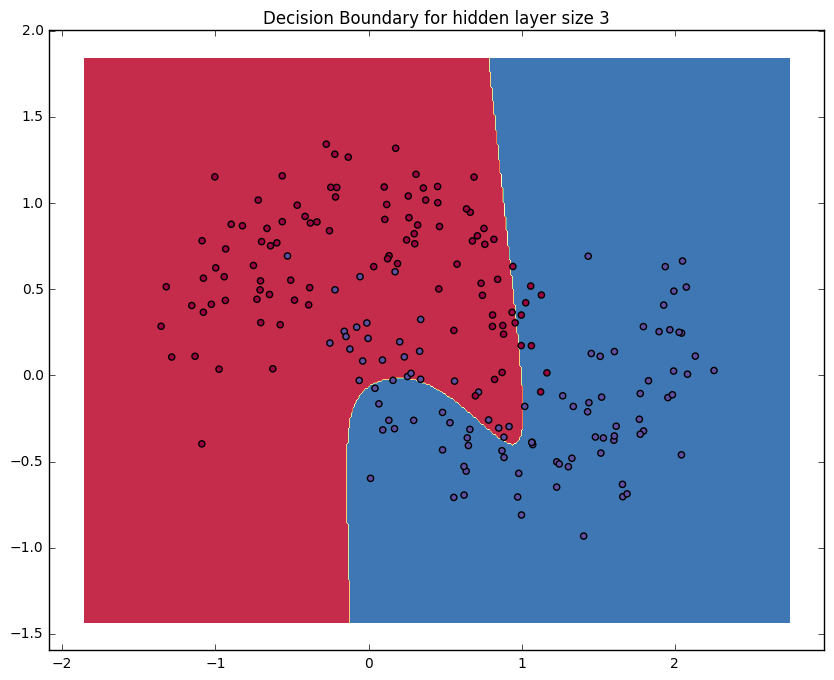

In [41]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [13]:
y_hat = predict(model, X)

y_hat

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [14]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def dsigmoid(x):
    return x * (1. - x)

epsilon = 0.01

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model_mini_relu(nn_hdim, num_passes=20000, print_loss=False, batch_size=40):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        for j in xrange(0, num_examples/batch_size):
            # mini_batch
            idx = np.random.choice(X.shape[0], batch_size, replace=False)
            X_mini = X[idx, :]
            y_mini = y[idx]
            
            # Forward propagation
            z1 = X_mini.dot(W1) + b1
            a1 = sigmoid(z1)
            z2 = a1.dot(W2) + b2
            exp_scores = np.exp(z2)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Backpropagation
            delta3 = probs
            delta3[range(batch_size), y_mini] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True) # keepdims=True, 不是必须
            delta2 = delta3.dot(W2.T) * dsigmoid(a1)
            dW1 = np.dot(X_mini.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model_mini_relu(3, print_loss=True)

Loss after iteration 0: 0.537633
Loss after iteration 1000: 0.153128
Loss after iteration 2000: 0.180888
Loss after iteration 3000: 0.164298
Loss after iteration 4000: 0.200334
Loss after iteration 5000: 0.198734
Loss after iteration 6000: 0.201319
Loss after iteration 7000: 0.180083
Loss after iteration 8000: 0.170515
Loss after iteration 9000: 0.195366
Loss after iteration 10000: 0.161116
Loss after iteration 11000: 0.207740
Loss after iteration 12000: 0.167877
Loss after iteration 13000: 0.183793
Loss after iteration 14000: 0.182708
Loss after iteration 15000: 0.176441
Loss after iteration 16000: 0.176716
Loss after iteration 17000: 0.177454
Loss after iteration 18000: 0.179672
Loss after iteration 19000: 0.181007


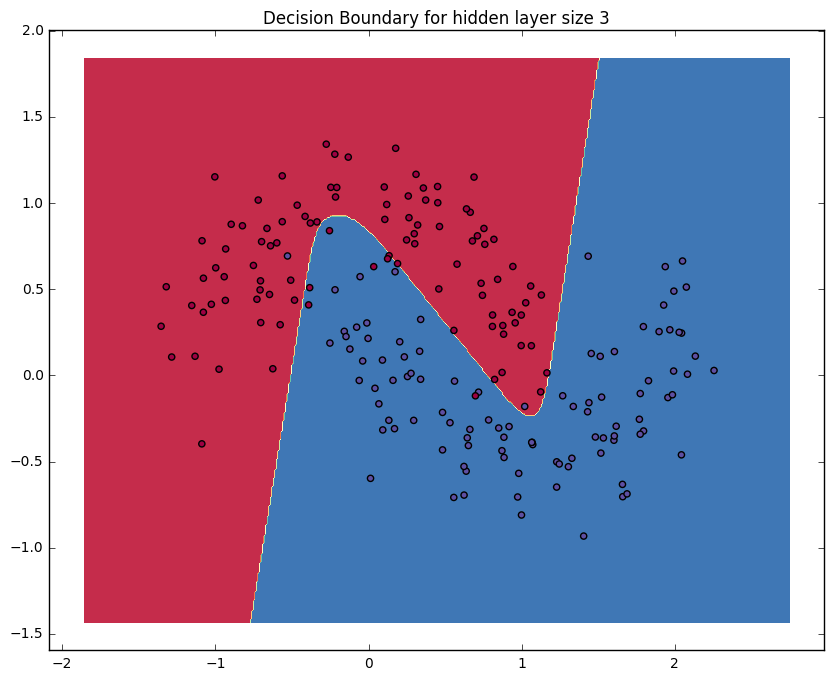

In [15]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

---

#### 4. three classes

In [16]:
sklearn.datasets.make_classification?

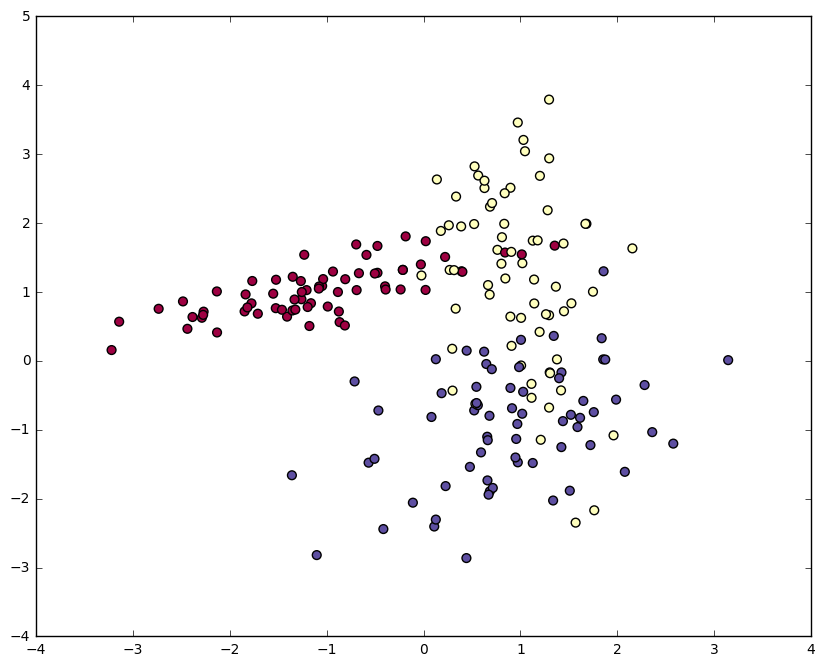

In [17]:
nn_output_dim = 3 # output layer dimensionality
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_classification(200, n_features=2, n_classes=nn_output_dim, n_redundant=0, n_clusters_per_class=1)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

Loss after iteration 0: 0.789454
Loss after iteration 1000: 0.298016
Loss after iteration 2000: 0.295913
Loss after iteration 3000: 0.294837
Loss after iteration 4000: 0.294417
Loss after iteration 5000: 0.294233
Loss after iteration 6000: 0.294142
Loss after iteration 7000: 0.294092
Loss after iteration 8000: 0.294063
Loss after iteration 9000: 0.294045
Loss after iteration 10000: 0.294033
Loss after iteration 11000: 0.294025
Loss after iteration 12000: 0.294020
Loss after iteration 13000: 0.294016
Loss after iteration 14000: 0.294013
Loss after iteration 15000: 0.294011
Loss after iteration 16000: 0.294010
Loss after iteration 17000: 0.294009
Loss after iteration 18000: 0.294008
Loss after iteration 19000: 0.294007


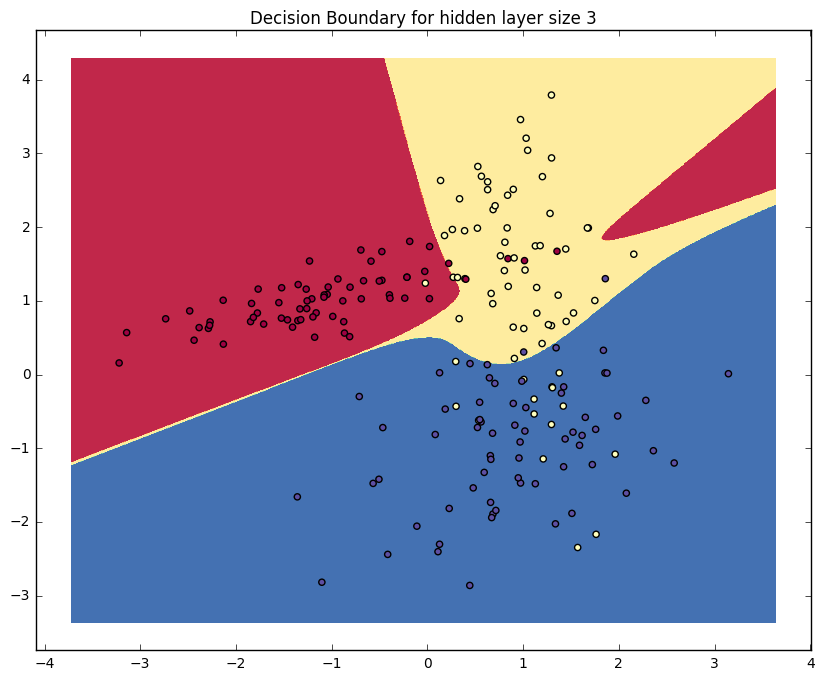

In [20]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

---

#### four layers

In [21]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model_4layers(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        a2 = np.tanh(z2)
        z3 = a2.dot(W3) + b3
        exp_scores = np.exp(z3)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta4 = probs
        delta4[range(num_examples), y] -= 1
        dW3 = (a2.T).dot(delta4)
        db3 = np.sum(delta4, axis=0, keepdims=True) # keepdims=True, 不是必须
        delta3 = delta4.dot(W3.T) * (1 - np.power(a2, 2))
        dW2 = np.dot(a1.T, delta3)
        db2 = np.sum(delta3, axis=0)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW3 += reg_lambda * W3
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        W3 += -epsilon * dW3
        b3 += -epsilon * db3
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        # print i
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss_4layers(model))
    
    return model

In [22]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss_4layers(model):
    num_examples = len(X)
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    z3 = a2.dot(W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [23]:
# Helper function to predict an output (0 or 1)
def predict_4layers(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    z3 = a2.dot(W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Loss after iteration 0: 0.619569
Loss after iteration 1000: 0.290465
Loss after iteration 2000: 0.287856
Loss after iteration 3000: 0.286117
Loss after iteration 4000: 0.285257
Loss after iteration 5000: 0.284845
Loss after iteration 6000: 0.284640
Loss after iteration 7000: 0.284536
Loss after iteration 8000: 0.284482
Loss after iteration 9000: 0.284455
Loss after iteration 10000: 0.284443
Loss after iteration 11000: 0.284440
Loss after iteration 12000: 0.284441
Loss after iteration 13000: 0.284445
Loss after iteration 14000: 0.284449
Loss after iteration 15000: 0.284454
Loss after iteration 16000: 0.284458
Loss after iteration 17000: 0.284461
Loss after iteration 18000: 0.284464
Loss after iteration 19000: 0.284466


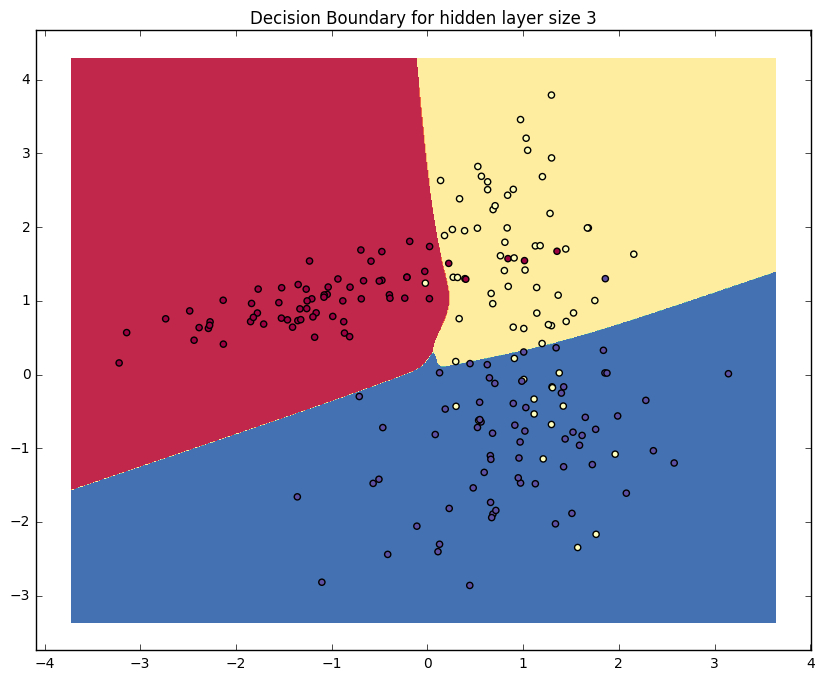

In [26]:
# Build a model with two 3-dimensional hidden layers
model = build_model_4layers(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict_4layers(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model_4layers(nn_hdim)
    plot_decision_boundary(lambda x: predict_4layers(model, x))
plt.show()